## Experiments with Embeddings

This notebook is used to experiment with different embeddings we retrieve from language models like BERT and GPT-2. 
Ultimately, words translated in different languages are plotted against each other to show the capabilities of cross-lingual embeddings.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

### 1. Single Sentence

#### Extract Embeddings from BERT

In [2]:
# from https://github.com/huggingface/transformers/issues/1950
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

MODEL_TYPE = 'bert-base-multilingual-uncased'
sequence = ["Today, the sun is shining."]

tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)
model = TFBertModel.from_pretrained(MODEL_TYPE)

In [3]:
def get_embeddings(sequence):
    input_ids = []
    outputs = []
    last_hidden_states_words = []
    last_hidden_states_sentence = []
    token_ids = []
    for index,sequ in enumerate(sequence):
        #print(index)
        #input_ids_multiple = [tf.constant(tokenizer.encode(sequences[index]))[None, :] for index,sequence in enumerate(sequences)] # Batch size 1

        input_ids.append(tf.constant(tokenizer.encode(sequ[index]))[None, :])

    #for index,sequ in enumerate(sequence):    
        outputs.append(model(input_ids[index]))
        last_hidden_states_words.append(outputs[index][0])
        last_hidden_states_sentence.append(outputs[index][1])
        #print(index)
        token_ids.append(tokenizer.encode_plus(sequ, max_length=50, pad_to_max_length=False)['input_ids'])

    return last_hidden_states_words, last_hidden_states_sentence, token_ids, labels

In [4]:
def get_embeddings_one_sentence(sequence):
    input_ids = tf.constant(tokenizer.encode(sequence[0]))[None, :] # Batch size 1
    outputs = model(input_ids)
    last_hidden_states_words = outputs[0]
    last_hidden_states_sentence = outputs[1]
    token_ids = tokenizer.encode_plus(sequence[0], max_length=50, pad_to_max_length=False)['input_ids']
    labels = [tokenizer.decode(int(token_id)) for token_id in token_ids]

    return last_hidden_states_words, last_hidden_states_sentence, token_ids, labels

In [5]:
hidden_words, hidden_sentence, tokens, labels = get_embeddings_one_sentence(sequence)
tokens

[101, 13980, 117, 10103, 13630, 10127, 76416, 119, 102]

In [6]:
# embeddings 
#input_ids = tf.constant(tokenizer.encode(sequence[0]))[None, :] # Batch size 1
#outputs = model(input_ids)
#last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [7]:
#outputs

In [8]:
#input_ids

In [9]:
#last_hidden_states

In [10]:
# tokens in a list format
#token_ids = tokenizer.encode_plus(sequence[0], max_length=50, pad_to_max_length=False)['input_ids']
#token_ids

In [11]:
#labels = [tokenizer.decode(int(token_id)) for token_id in token_ids]
#labels

In [12]:
#outputs = model(input_ids)

In [13]:
#last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [14]:
#type(last_hidden_states[0])

#### Dimensionality Reduction

##### t-SNE

In [15]:
# adapted from https://github.com/ioannispartalas/CrossLingual-NLP-AMLD2020/blob/master/notebooks/AMLD%20Intro.ipynb

# For more information of TSNE: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [16]:
# error for three dimensions

def plot_embeddings(tokens,labels,sequences,dimensions=2,force_simple=False):
    '''
    Plots the embeddings together with the token names in a 2-dimensional space.
    
    Args:
        tokens:         list (of lists) of the tokens
        labels:         concatenated list of all the labels of the tokens
        sequences:      list of input strings to be tokenized
        dimensions:     defines the dimensions of the plot, at the moment only 2 works
        force_simple:   forces the function to handle the input sequence as if it were a single sequence
        
    Outputs: embedding plot
    '''
    tsne_model = TSNE(perplexity=1.5, n_components=dimensions, init='pca', n_iter=2500, random_state=23)
    
    print(len(sequences))
    
    if len(sequences)>1 and force_simple==False:
        tsne_inputs = []
        for index,sequence in enumerate(sequences):
            tsne_inputs.append(np.array(tokens[index][0]))

        tsne_outputs = []
        for index,sequence in enumerate(sequences):
            tsne_outputs.append(tsne_model.fit_transform(np.array(tsne_inputs[index])))

        x = [list(zip(*tsne_outputs[index]))[0] for index,sequence in enumerate(sequences)]
        y = [list(zip(*tsne_outputs[index]))[1] for index,sequence in enumerate(sequences)]
        if dimensions == 3:
            z = [list(zip(*tsne_outputs[index]))[2] for index,sequence in enumerate(sequences)]


        plt.figure(figsize=(7, 6)) 
        if dimensions == 2:
            for index in range(len(sequences)):
                plt.scatter(x[index],y[index])

                print(len(x[index]))

                for i in range(len(x[index])):
                    if index != 0:
                        #i+index*len(x[index-1]) for the second loop is (0-10)+1*9 (which is the length of the previous iteration)
                        
                        #print(i+index*len(x[index-1]))
                        #print(index)
                        plt.annotate(labels[i+(index-1)*len(x[index-1])],
                                     xy=(x[index][i], y[index][i]),
                                     xytext=(5, 2),
                                     textcoords='offset points',
                                     ha='right',
                                     va='bottom')
                    else:
                        plt.annotate(labels[i],
                                     xy=(x[index][i], y[index][i]),
                                     xytext=(5, 2),
                                     textcoords='offset points',
                                     ha='right',
                                     va='bottom')
        #elif dimensions == 3:
            #for index in range(len(sequences)):
            #    plt.scatter(x[index],y[index],z[index])

            #    print(len(x[index]))

            #    for i in range(len(x[index])):
            #        if index != 0:
            #            #i+index*len(x[index-1]) for the second loop is (0-10)+1*9 (which is the length of the previous iteration)
            #            plt.annotate(labels[i+index*len(x[index-1])],
            #                         xyz=(x[index][i], y[index][i], z[index][i]),
            #                         xyztext=(5, 2, 2),
            #                         textcoords='offset points',
            #                         ha='right',
            #                         va='bottom')
            #        else:
            #            plt.annotate(labels[i],
            #                         xyz=(x[index][i], y[index][i], z[index][i]),
            #                         xytext=(5, 2, 2),
            #                         textcoords='offset points',
            #                         ha='right',
            #                         va='bottom')
            #            
    else:
        tsne_outputs = tsne_model.fit_transform(tokens)
        print(tsne_outputs)

        x = tsne_outputs[:,0]
        y = tsne_outputs[:,1]
        if dimensions == 3:
            z = tsne_outputs[:,2]


        plt.figure(figsize=(7, 6)) 
        
        if dimensions == 2:
            plt.scatter(x,y)

            print(len(x))
            print(len(labels))
            for i in range(len(x)):
                plt.annotate(labels[i],
                             xy=(x[i], y[i]),
                             xytext=(5, 2),
                             textcoords='offset points',
                             ha='right',
                             va='bottom')
        
        #elif dimensions == 3:
            #plt.scatter(x,y,z)

            #print(len(x))
            #print(len(labels))
            #for i in range(len(x)):
            #    plt.annotate(labels[i],
            #                 xyz=(x[i], y[i], z[i]),
            #                 xyztext=(5, 2, 2),
            #                 textcoords='offset points',
            #                 ha='right',
            #                 va='bottom')

In [17]:
def plot_embeddings_old(tokens,labels,sequences):
    tsne_model = TSNE(perplexity=1.5, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = new_values[:,0]
    y = new_values[:,1]


    plt.figure(figsize=(7, 6)) 
    if len(sequences)>1:
        
        flatten_tokens = [item for sublist in token_ids_multiple for item in sublist]
        start_next_sequence = int(len(flatten_tokens) / len(sequences))

        plt.scatter(x[:start_next_sequence],y[:start_next_sequence])

        for index,sequence in enumerate(sequences[1:]):
            print(start_next_sequence*index)
            print(type(start_next_sequence*index))
            plt.scatter(x[start_next_sequence*index:],y[start_next_sequence*index:])
    else:
        plt.scatter(x,y)

        print(len(x))
        print(len(labels))
        for i in range(len(x)):
            plt.annotate(labels[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')

In [18]:
#last_hidden_states.numpy()[0].shape

In [19]:
#tokens = last_hidden_states.numpy()[0].tolist()
#len(tokens)

In [20]:
#type(tokens)

In [21]:
#len(sequence)


In [22]:
hidden_words

<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[-0.00212247, -0.0423057 , -0.03695792, ...,  0.01820284,
         -0.18701142,  0.03091387],
        [ 0.10887855,  0.06550951, -0.37081748, ...,  0.21875395,
         -0.36431113, -0.08754858],
        [ 0.20696844, -0.19406173, -0.28209594, ..., -0.09924239,
         -0.6044725 ,  0.06912345],
        ...,
        [ 0.17756762,  0.31336808,  0.01536575, ...,  0.12102035,
         -0.3919026 ,  0.33771276],
        [-0.12370283,  0.5159705 , -0.29101202, ..., -0.21107562,
         -0.38868165, -0.14851297],
        [-0.01811093,  0.09140886, -0.5503057 , ...,  0.50499874,
         -0.39168778, -0.33403742]]], dtype=float32)>

In [23]:
tokens = hidden_words.numpy()[0].tolist()

1
[[-394.56058  -109.6698  ]
 [-215.80551  -109.076035]
 [ 140.43478   207.23369 ]
 [  78.23175   152.68297 ]
 [-215.91455   -22.702023]
 [ 114.03585   183.96027 ]
 [-234.49672   -53.994675]
 [-292.7625    -73.72323 ]
 [-350.40265   -91.527214]]
9
9


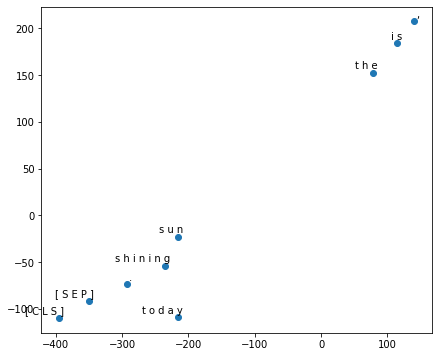

In [24]:
plot_embeddings(tokens,labels,sequence,2)

9
9


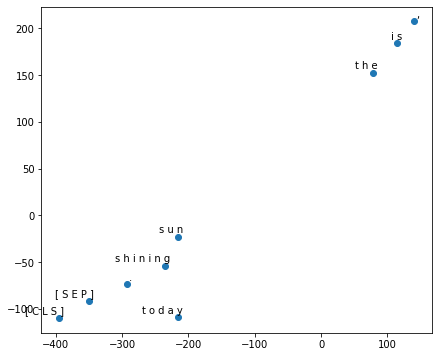

In [25]:
plot_embeddings_old(tokens,labels,sequence)

### 2. Multiple Sentences

#### Extract Embeddings from BERT

In [26]:
sequences = ["The sun is shining today.","Heute scheint die Sonne.","Aujourd'hui, le soleil brille."]


In [27]:
hidden_words_mult, hidden_sentence_mult, tokens_mult, labels_mult = get_embeddings(sequences)
tokens_mult

[[101, 10103, 13630, 10127, 76416, 13980, 119, 102],
 [101, 12830, 63670, 10121, 55772, 119, 102],
 [101, 17988, 112, 16645, 117, 10130, 33175, 32949, 10111, 119, 102]]

In [28]:
#input_ids_multiple = []
#outputs_multiple = []
#last_hidden_states_multiple = []
#token_ids_multiple = []
#for index,sequence in enumerate(sequences):
#    print(index)
#    #input_ids_multiple = [tf.constant(tokenizer.encode(sequences[index]))[None, :] for index,sequence in enumerate(sequences)] # Batch size 1

#    input_ids_multiple.append(tf.constant(tokenizer.encode(sequences[index]))[None, :])

#for index,sequence in enumerate(sequences):    
#    outputs_multiple.append(model(input_ids_multiple[index]))
#    last_hidden_states_multiple.append(outputs_multiple[index][0])
#    token_ids_multiple.append(tokenizer.encode_plus(sequences[index], max_length=50, pad_to_max_length=False)['input_ids'])


In [29]:
#input_ids_multiple

In [30]:
#outputs_multiple[1][0]

In [31]:
#last_hidden_states_multiple

In [32]:
# tokens
#token_ids_multiple

In [33]:
# this is not used anymore
#flatten_tokens_multiple = [item for sublist in token_ids_multiple for item in sublist]
#flatten_tokens_multiple

In [34]:
#labels_multiple = [tokenizer.decode(int(token_id)) for token_id in flatten_tokens_multiple] 
#labels_multiple

In [35]:
#print(len(labels_multiple), len(flatten_tokens_multiple))

#### Dimensionality Reduction

##### T-SNE

In [36]:
#tsne_inputs = []
#for index,sequence in enumerate(sequences):
#    tsne_inputs.append(np.array(last_hidden_states_multiple[index][0]))

In [37]:
#tsne_model = TSNE(perplexity=1.5, n_components=2, init='pca', n_iter=2500, random_state=23)
#tsne_outputs = []
#for index,sequence in enumerate(sequences):
#    tsne_outputs.append(tsne_model.fit_transform(np.array(tsne_inputs[index])))
    
#tsne_outputs
#new_values = [tsne_model.fit_transform(last_hidden_states_multiple) for sequence in sequences]
#new_values
#np.array(new_values)

In [38]:
#print(len(list(zip(*tsne_outputs[0]))[0]), \
#len(list(zip(*tsne_outputs[1]))[0]))

In [39]:
#x = [list(zip(*tsne_outputs[index]))[0] for index,sequence in enumerate(sequences)]
#y = [list(zip(*tsne_outputs[index]))[1] for index,sequence in enumerate(sequences)]
#x
#tsne_outputs[0][:]
#tsne_outputs[:,0]
#tsne_outputs[index_sequence][index_array][0]

In [40]:
#next(zip(*tsne_outputs))

In [41]:
#all_tokens_multiple = [last_hidden_states_multiple[index][0] for index,sequence in enumerate(sequences)]
#all_tokens_multiple
#all_tokens_multiple[0].numpy()[0].shape
#all_tokens_multiple[0].numpy()[0].tolist()

In [42]:
#tokens_multiple = [all_tokens_multiple[index].numpy()[0].tolist() for index,sequence in enumerate(sequences)][0]

In [43]:
#print("tokens: ",len(tokens_multiple),"  dimensions: ",len(tokens_multiple[0]))

In [44]:
#len(all_tokens_multiple[0])

In [45]:
#tsne_model = TSNE(perplexity=1.5, n_components=2, init='pca', n_iter=2500, random_state=23)
#new_values = [tsne_model.fit_transform(tokens_multiple) for sequence in sequences]
#new_values
#np.array(new_values)

In [46]:
#sequence_1 = tsne_model.fit_transform(tokens_multiple[:len(tokens_multiple[0])])
#sequence_1

In [47]:
#sequence_2 = tsne_model.fit_transform(tokens_multiple[len(tokens_multiple[0]):])
#sequence_2

In [48]:
#len(x[0])

In [49]:
#range(len(sequences))

In [50]:
#tsne_model = TSNE(perplexity=1.5, n_components=2, init='pca', n_iter=2500, random_state=23)
#new_values = [tsne_model.fit_transform(tokens_multiple) for sequence in sequences]


#plt.figure(figsize=(7, 6)) 
#for index in range(len(sequences)):
#    plt.scatter(x[index],y[index])
#    for i in range(len(x[index])):
#        plt.annotate(labels_multiple[i],
#                     xy=(x[index][i], y[index][i]),
#                     xytext=(5, 2),
#                     textcoords='offset points',
#                     ha='right',
#                     va='bottom')

In [51]:
#tsne_model = TSNE(perplexity=1.5, n_components=2, init='pca', n_iter=2500, random_state=23)
#new_values = tsne_model.fit_transform(tokens)

#x = new_values[:,0]
#y = new_values[:,1]

#start_next_sequence = int(len(tokens) / len(sequences))

#plt.figure(figsize=(7, 6)) 
#plt.scatter(x[:start_next_sequence],y[:start_next_sequence])
#plt.scatter(x[start_next_sequence:],y[start_next_sequence:])

#for i in range(len(x)):
#    plt.annotate(labels[i],
#                 xy=(x[i], y[i]),
#                 xytext=(5, 2),
#                 textcoords='offset points',
#                 ha='right',
#                 va='bottom')

3
3
3
3


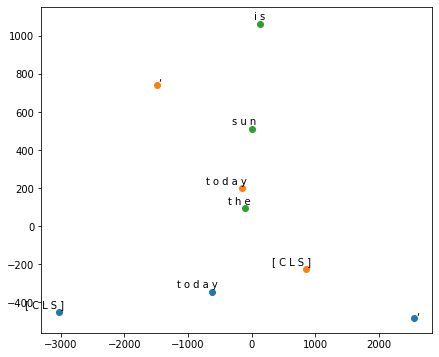

In [52]:
#hidden_words_mult, hidden_sentence_mult, tokens_mult, labels_mult
plot_embeddings(hidden_words_mult,labels_mult,sequences,2)

In [53]:
#plot_embeddings(last_hidden_states_multiple,labels_multiple,sequences,3)
# dimension 3 requires a z axis and a new plot...

### Word translations

In [54]:
words_en = ["sun","dog","queen","king","street","wonderful","car"]
words_de = ["Sonne","Hund","Königin","König","Strasse","wunderbar","Auto"]
words_fr = ["soleil","chien","reine","roi","rue","magnifique","voiture"]

In [55]:
words_en_tokenized = [tokenizer.tokenize(words) for words in words_en]
words_de_tokenized = [tokenizer.tokenize(words) for words in words_de]
words_fr_tokenized = [tokenizer.tokenize(words) for words in words_fr]

In [56]:
#words = [words_en, words_de, words_fr]
words = ["sun","dog","queen","king","street","wonderful","car","soleil","chien","reine","roi","rue","magnifique","voiture"]
#"Sonne","Hund","Königin","König","Strasse","wunderbar","Auto",
words

['sun',
 'dog',
 'queen',
 'king',
 'street',
 'wonderful',
 'car',
 'soleil',
 'chien',
 'reine',
 'roi',
 'rue',
 'magnifique',
 'voiture']

In [57]:
len(words)

14

In [58]:
#get_embeddings(words)

In [59]:
# embeddings 
#input_ids_words = []
#token_ids_words = []
#for index,languages in enumerate(words):
#    input_ids_words.append(tf.constant(tokenizer.encode(words[index]))[None, :]) # Batch size 1
#    token_ids_words.append(tokenizer.encode_plus(words[index], max_length=50, pad_to_max_length=False)['input_ids'])
input_ids_words = tf.constant(tokenizer.encode(words))[None, :]
outputs_words = model(input_ids)
last_hidden_states_words = outputs[0]  # The last hidden-state is the first element of the output tuple
token_ids_words = tokenizer.encode_plus(words, max_length=50, pad_to_max_length=False)['input_ids']

NameError: name 'input_ids' is not defined

In [ ]:
input_ids_words

In [ ]:
tokenizer.encode(["schon"])

In [ ]:
outputs_words[0]

In [ ]:
# for some reason, it does not tokenize the german words correctly!
token_ids_words

In [ ]:
labels_words = [tokenizer.decode(int(token_id)) for token_id in token_ids_words]
labels_words

In [ ]:
plot_input_words = last_hidden_states_words.numpy()[0].tolist()

In [ ]:
plot_embeddings(plot_input_words,labels_words,words,2,force_simple=True)

### Experiment with Embeddings for the Same Word

In [ ]:
similar_sequences = ["I am working from home today.","Has Fred come home from work yet?","You live at home but you need to work at the office."]

In [ ]:
input_ids_similar = []
outputs_similar = []
last_hidden_states_similar = []
token_ids_similar = []
for index,sequence in enumerate(similar_sequences):
    print(index)
    #input_ids_multiple = [tf.constant(tokenizer.encode(sequences[index]))[None, :] for index,sequence in enumerate(sequences)] # Batch size 1

    input_ids_similar.append(tf.constant(tokenizer.encode(similar_sequences[index]))[None, :])

#for index,sequence in enumerate(sequences):    
    outputs_similar.append(model(input_ids_similar[index]))
    last_hidden_states_similar.append(outputs_similar[index][0])
    token_ids_similar.append(tokenizer.encode_plus(similar_sequences[index], max_length=50, pad_to_max_length=False)['input_ids'])


In [ ]:
flatten_tokens_similar = [item for sublist in token_ids_similar for item in sublist]
flatten_tokens_similar

In [ ]:
labels_similar = [tokenizer.decode(int(token_id)) for token_id in flatten_tokens_similar]
labels_similar

In [ ]:
plot_embeddings(last_hidden_states_similar,labels_similar,similar_sequences,2)

#plot_embeddings(plot_input_words,labels_words,words,2,force_simple=True)

### Represent the whole sentence

### Alternative Approach

In [ ]:
# following https://colab.research.google.com/drive/1TCgnpIwsr6uK4cP0Gk1RCCQrFy6s3Xc1

#pip install bert-embedding
from bert_embedding import BertEmbedding


In [ ]:
bert_embedding = BertEmbedding()


In [ ]:
# from: https://towardsdatascience.com/visualisation-of-embedding-relations-word2vec-bert-64d695b7f36

def get_visual_embs(sentence):
    """Get BERT embedding for the sentence,
    project it to a 2D subspace where [CLS] is (1,0) and [SEP] is (0,1)."""
    embs = bert_embedding([sentence])#, filter_spec_tokens=False)
    tokens = embs[0][0]
    embV = embs[0][1]
    W = np.array(embV)

    B = np.array([embV[0], embV[-1]])
    Bi = np.linalg.pinv(B.T)
    Wp = np.matmul(Bi,W.T)

    return Wp, tokens

In [ ]:
embs = get_visual_embs("The sun is shining bright.")
embs

In [ ]:
#sentences = ['The sky is blue today.', 'The sea is blue today.']
sentences = similar_sequences
colors = ['blue', 'red', 'green']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(Wp)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))

        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if txt == 'sky':
            plt.annotate(txt, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if txt == 'sea':
            plt.annotate(txt, (Wp[0,i]+rX*eps*2, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

##### Tenses

In [ ]:
sentences = ['This is a horrible idea!', 'This was a horrible idea!', 'This will be a horrible idea!']
colors = ['blue', 'red', 'green']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        #plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

##### Punctuation

In [ ]:
sentences = ['This is a horrible idea.', 'This is a horrible idea!', 'This is a horrible idea?']
colors = ['blue', 'red', 'green', 'yellow']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        #plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

##### Complex Sentences

In [ ]:
# Some sentences from here: https://sentence.yourdictionary.com/mexico
sentences = ["In Mexico the national government is carrying out a consistent policy of developing its railway lines.", 
             "Borlaug also promoted the process (which proved wildly successful) of having two wheat-growing seasons in Mexico, one in the highlands, then another in the valley regions.",
             "That's in Mexico, too.",
             "In 1904 he went to Japan as war correspondent and in 1914 to Mexico in the same capacity."]
colors = ['blue', 'red', 'green', 'grey', 'purple', 'orange', 'lightblue', 'yellow']

plt.figure(figsize=(24,9))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if txt=='mexico':
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

##### Non-real Sentences

In [ ]:
# Some sentences from here: https://sentence.yourdictionary.com/mexico
sentences = ["The the the the the the the the the", 
             ". . . . . . . . . . .",
             "gre htrha hthateh heta ger er",
             "The sky is blue today.",
             "James Cook was a very good man and a loving husband."]
colors = ['blue', 'red', 'green', 'grey', 'purple', 'orange', 'lightblue', 'yellow']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()